In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# be careful with that:
import warnings
warnings.filterwarnings('ignore')

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures


from sklearn.linear_model import LogisticRegression


from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

from sklearn.ensemble import IsolationForest


from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, confusion_matrix, recall_score, pairwise_distances_argmin_min
from sklearn.metrics import roc_auc_score, roc_curve, adjusted_rand_score, precision_recall_curve, precision_score, f1_score

from sklearn.svm import OneClassSVM

from scipy.stats import uniform, chisquare, binomtest

from itertools import product

from IPython.display import clear_output


In [5]:
# load data

#data_6p_t2m = pd.read_csv('../datasets/A_data_heatmap_300x250_6p_t2m.csv')
#data_6p_h2m = pd.read_csv('../datasets/A_data_heatmap_300x250_6p_h2m.csv')

#data_metrics = pd.read_csv('../A_data_domain_perf_metrics_300x250_3p.csv')

In [6]:
#combine data
#data_6p_combined = pd.concat([data_6p_t2m,data_6p_t2m])

In [12]:
#data_6p_combined.to_csv('../datasets/data_6p_combined.csv', index=False)
data_heatmap = pd.read_csv('../datasets/data_6p_combined.csv')

### Training Data(old)

In [2]:
#!python3 pca_pipeline.py 333519 200 '../datasets/train/data_heatmap_train.csv'
!python3 pca_pipeline_combine_gridid.py 200 '../datasets/train/data_heatmap_train.csv'

pca_df = pd.read_csv('temp/pca_df.csv')
pca_df = pca_df.iloc[:,1:]
pca_df_inp = pca_df.iloc[:,:-2]
y_train = pca_df['label'].values

Nb components:  200
Data directory:  ../datasets/train/data_heatmap_train.csv


### Test Data(new)

In [3]:
#!python3 pca_pipeline.py 333519 200 '../datasets/test/data_heatmap_test.csv'
!python3 pca_pipeline_combine_gridid.py 200 '../datasets/data_6p_combined.csv'

pca_test = pd.read_csv('temp/pca_df.csv')
pca_test = pca_test.iloc[:,1:]
y_test = pca_test[['label']].values

Nb components:  200
Data directory:  ../datasets/data_6p_combined.csv


### SVM

In [31]:
# Best Model is with 178 PCA dimensions
pca_dim = 178

X_train = pca_df_inp.iloc[:,:pca_dim]
X_test = pca_test.iloc[:,:pca_dim]

oneclass = OneClassSVM(gamma = 'auto').fit(X_train)
oneclass_labels = oneclass.predict(X_test)
    
oneclass_labels = np.where(oneclass_labels == 1, 0,1)
conf_mat   = confusion_matrix(y_test,oneclass_labels)
acc        = accuracy_score(y_test,oneclass_labels)
recall     = recall_score(y_test,oneclass_labels)
prec       = precision_score(y_test,oneclass_labels)
f1         = f1_score(y_test,oneclass_labels)

print(f'Confusion matrix for {pca_dim} PCA dimensions:\n', 
              f' {conf_mat}')
#print(f'Accuracy for {pca_dim} PCA dimensions:', 
#              f' {acc:.2f}')
#print(f'Recall for {pca_dim} PCA dimensions:', 
#              f' {recall:.2f}')
#print(f'Precision for {pca_dim} PCA dimensions:', 
#              f' {prec:.2f}')
print(f'F1 Score for {pca_dim} PCA dimensions:', 
              f' {f1:.2f}')

Confusion matrix for 178 PCA dimensions:
  [[308 475]
 [  8   5]]
F1 Score for 178 PCA dimensions:  0.02


### KNN

In [32]:
# Perform PCA on X_train and X_test with 10 dimensions
PCA = 10
nn = 10
thres = 90

X_train = pca_df_inp.iloc[:, :PCA]  
X_test = pca_test.iloc[:, :PCA] 

# Train k-NN model on X_train_pca with 10 neighbors
knn = NearestNeighbors(n_neighbors=nn, algorithm='auto', metric='euclidean')
knn.fit(X_train)

# Predict anomalies on X_test_pca
distances, indices = knn.kneighbors(X_test)
anomaly_scores = distances.mean(axis=1)
threshold = np.percentile(anomaly_scores, thres)

# Convert labels to binary (0: inliers, 1: outliers)
knn_labels = np.where(anomaly_scores > threshold, 1, 0)

# Evaluate the performance on X_test
conf_mat = confusion_matrix(y_test, knn_labels)
acc = accuracy_score(y_test, knn_labels)
f1 = f1_score(y_test, knn_labels)

print(f'Confusion matrix on X_test:\n{conf_mat}')
print(f'Accuracy on X_test: {acc:.2f}')
print(f'F1 Score on X_test: {f1:.2f}')
print("Predicted knn labels:")
print(knn_labels)

Confusion matrix on X_test:
[[703  80]
 [ 13   0]]
Accuracy on X_test: 0.88
F1 Score on X_test: 0.00
Predicted knn labels:
[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 1 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0

### K Cluster

In [33]:
pca = 2
k = 2

X = pca_df_inp.iloc[:,:pca]
kmeans = KMeans(n_clusters = k, random_state=42)
kmeans.fit(X)
kmeans_labels = kmeans.predict(pca_test.iloc[:,:pca])
conf_mat = confusion_matrix(y_test,kmeans_labels)
acc = accuracy_score(y_test,kmeans_labels)
recall = recall_score(y_test,kmeans_labels)
prec = precision_score(y_test,kmeans_labels)
f1 = f1_score(y_test,kmeans_labels)
print(conf_mat)
print(f'Test accuracy: {acc:.2f}')
print(f'Test precision: {prec:.2f}')
print(f'Test recall: {recall:.2f}')
print(f'Test f1-score: {f1:.2f}')

[[259 524]
 [  4   9]]
Test accuracy: 0.34
Test precision: 0.02
Test recall: 0.69
Test f1-score: 0.03


### DBSCAN

In [34]:
PCA = 8
eps = 5
min_sam = 10

# Apply PCA with 8 dimensions
X_train = pca_df_inp.iloc[:, :PCA]  
X_test = pca_test.iloc[:, :PCA] 

# Fit DBSCAN model
dbscan = DBSCAN(eps=eps, min_samples=min_sam)
dbscan_labels_train = dbscan.fit_predict(X_train)
dbscan_labels_test = dbscan.fit_predict(X_test)

# Convert labels to binary (0: inliers, 1: outliers)
dbscan_labels_train = np.where(dbscan_labels_train >= 0, 0, 1)
dbscan_labels_test = np.where(dbscan_labels_test >= 0, 0, 1)

# Evaluate performance on test data
conf_mat_test = confusion_matrix(y_test, dbscan_labels_test)
acc_test = accuracy_score(y_test, dbscan_labels_test)
f1_test = f1_score(y_test, dbscan_labels_test)

print("\nPerformance on test data:")
print("Confusion matrix:")
print(conf_mat_test)
print("Accuracy:", acc_test)
print("F1 Score:", f1_test)
print("Predicted DBScan labels:")
print(dbscan_labels_test)


Performance on test data:
Confusion matrix:
[[684  99]
 [ 13   0]]
Accuracy: 0.8592964824120602
F1 Score: 0.0
Predicted DBScan labels:
[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 1 0 1 1 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 1 1 0 0 0 1 0 1 0 0 0 1 0 0 1 1 1 0 

### Isolation Forest

In [4]:
#Best Model for Isolation Forest is with 10 PCA and n_estimators = 100
pca_dim = 10
best_n_est = 100
X_train = pca_df_inp.iloc[:,:pca_dim]
X_test = pca_test.iloc[:,:pca_dim]
            
isolation_forest = IsolationForest(n_estimators=best_n_est, 
                                   max_samples='auto', 
                                   random_state=42)

model = isolation_forest.fit(X_train)
if_labels = model.predict(X_test)
if_labels = np.where(if_labels == -1, 1, 0)

conf_mat   = confusion_matrix(y_test,if_labels)
acc        = accuracy_score(y_test,if_labels)
recall     = recall_score(y_test,if_labels)
prec       = precision_score(y_test,if_labels)
f1         = f1_score(y_test, if_labels)


print(f'Confusion matrix for {pca_dim} PCA dimensions:\n', 
                      f' {conf_mat}')
#print(f'Accuracy for {pca_dim} PCA dimensions:', 
#                      f' {acc:.2f}')
#print(f'Recall for {pca_dim} PCA dimensions:', 
#                      f' {recall:.2f}')
#print(f'Precision for {pca_dim} PCA dimensions:', 
#                      f' {prec:.2f}')
print(f'F1 Score for {pca_dim} PCA dimensions with n_estimator = {best_n_est}:', 
                      f' {f1:.2f}')
print(f'---------')

Confusion matrix for 10 PCA dimensions:
  [[699  84]
 [ 13   0]]
F1 Score for 10 PCA dimensions with n_estimator = 100:  0.00
---------


### Combined result

In [35]:
tot = 5
thresh = 1
comb_labels = if_labels + oneclass_labels + dbscan_labels_test + \
kmeans_labels + knn_labels
comb_labels = np.where(comb_labels > tot//2 + thresh, 1, 0)


## Result exploration

In [22]:
# expand so that each row corresponds to 1 click:
data_heatmap_expanded = data_heatmap.loc[data_heatmap.index.repeat(data_heatmap['clicks'])].reset_index(drop=True)
data_heatmap_expanded['clicks'] = 1

click_stat = data_heatmap_expanded.groupby(['click_x','click_y'])['clicks'].count().reset_index()

# number of bins for the grid
NR_OF_X_BINS = 61  # 60 bins + 1 for edge
NR_OF_Y_BINS = 51  # 50 bins + 1 for edge

# bin edges
max_width = data_heatmap['display_width'].max()
max_height = data_heatmap['display_height'].max()

width_bins = np.linspace(1, max_width, NR_OF_X_BINS)
height_bins = np.linspace(1, max_height, NR_OF_Y_BINS)

width_bins_max = len(width_bins)-2 # start at 0
height_bins_max = len(height_bins)-2

data_heatmap_expanded['click_x_bin'] = pd.cut(data_heatmap_expanded['click_x'], 
                                      bins   = width_bins, 
                                      labels = False, 
                                      include_lowest = True)

data_heatmap_expanded['click_y_bin'] = pd.cut(data_heatmap_expanded['click_y'], 
                                      bins = height_bins, 
                                      labels = False, 
                                      include_lowest = True)
aggregated_clicks = data_heatmap_expanded.groupby(['grid_id',
                                           'domain', 
                                           'click_x_bin', 
                                           'click_y_bin']).size().reset_index(name='clicks_sum')

# multi-index by setting grid_id, domain, click_x_bin, and click_y_bin as indices
#aggregated_clicks.set_index(['grid_id', 'domain', 'click_x_bin', 'click_y_bin'], inplace=True)


In [84]:
print(f'anomaly percentage: {sum(comb_labels)/len(comb_labels)*100}')

anomaly percentage: 7.788944723618091


In [37]:
print(f'number of broken banner predicted: {sum(comb_labels)}')

number of broken banner predicted: 62


In [38]:
pca_test['predicted_result'] = comb_labels

In [69]:
anomalies_domains_519 = pca_test[(pca_test['predicted_result'] == 1) & (pca_test['grid_id'] == 333519)]
anomalies_domains_346 = pca_test[(pca_test['predicted_result'] == 1) & (pca_test['grid_id'] == 333346)]

In [76]:
anomalies_clicks_519 = aggregated_clicks[
    (aggregated_clicks['domain'].isin(anomalies_domains_519['domain'].values)) & 
    (aggregated_clicks['grid_id'] == 333519)
]


In [78]:
anomalies_clicks_346 = aggregated_clicks[
    (aggregated_clicks['domain'].isin(anomalies_domains_346['domain'].values)) & 
    (aggregated_clicks['grid_id'] == 333346)
]


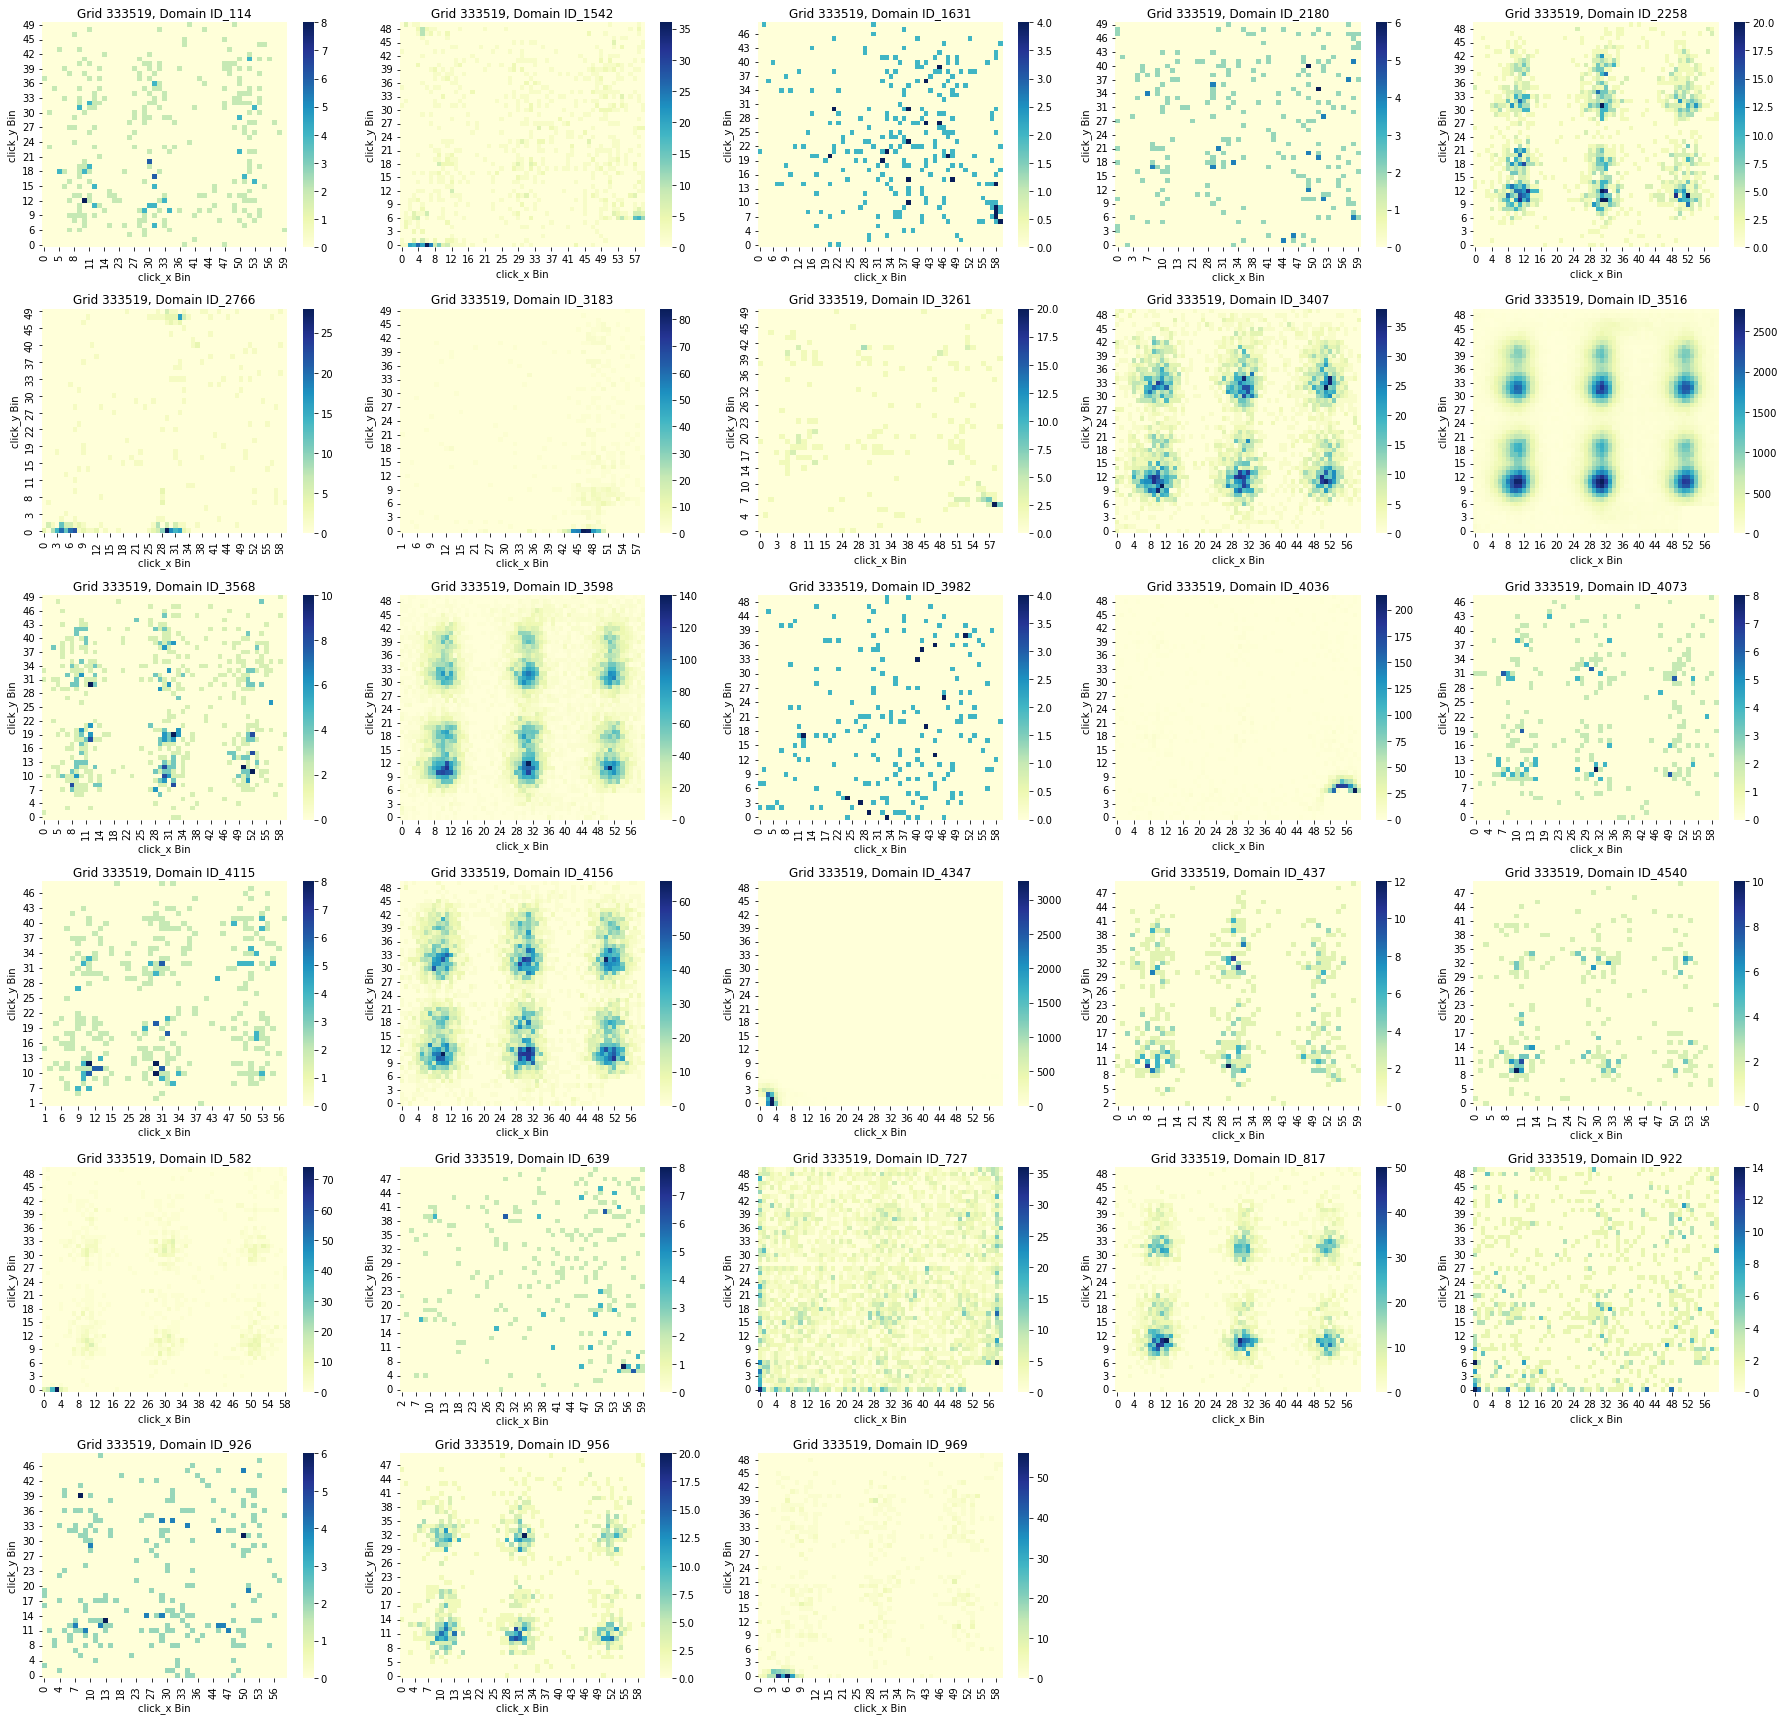

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns

# Determine the number of unique pairs of (grid_id, domain)
n_unique_pairs = anomalies_clicks_519.groupby(['grid_id', 'domain']).ngroups

# Decide on the layout of the subplots (for example, a grid of 5x5 subplots if there are 25 unique pairs)
n_rows = int(np.ceil(np.sqrt(n_unique_pairs)))
n_cols = int(np.ceil(n_unique_pairs / n_rows))

# Create a large figure to accommodate all the subplots
plt.figure(figsize=(n_cols * 5, n_rows * 4))

# Iterate over each group, creating a subplot for each
for i, ((grid_id, domain), group) in enumerate(anomalies_clicks_519.groupby(['grid_id', 'domain']), start=1):
    click_matrix = group.pivot("click_y_bin", "click_x_bin", "clicks_sum").fillna(0)
    
    # Create a subplot for the current heatmap
    ax = plt.subplot(n_rows, n_cols, i)
    sns.heatmap(click_matrix, cmap="YlGnBu", annot=False, cbar=True, fmt="g", ax=ax)
    ax.set_title(f'Grid {grid_id}, Domain {domain}')
    ax.set_xlabel('click_x Bin')
    ax.set_ylabel('click_y Bin')
    ax.invert_yaxis() 

# Adjust the layout to prevent overlap
plt.tight_layout()
plt.show()


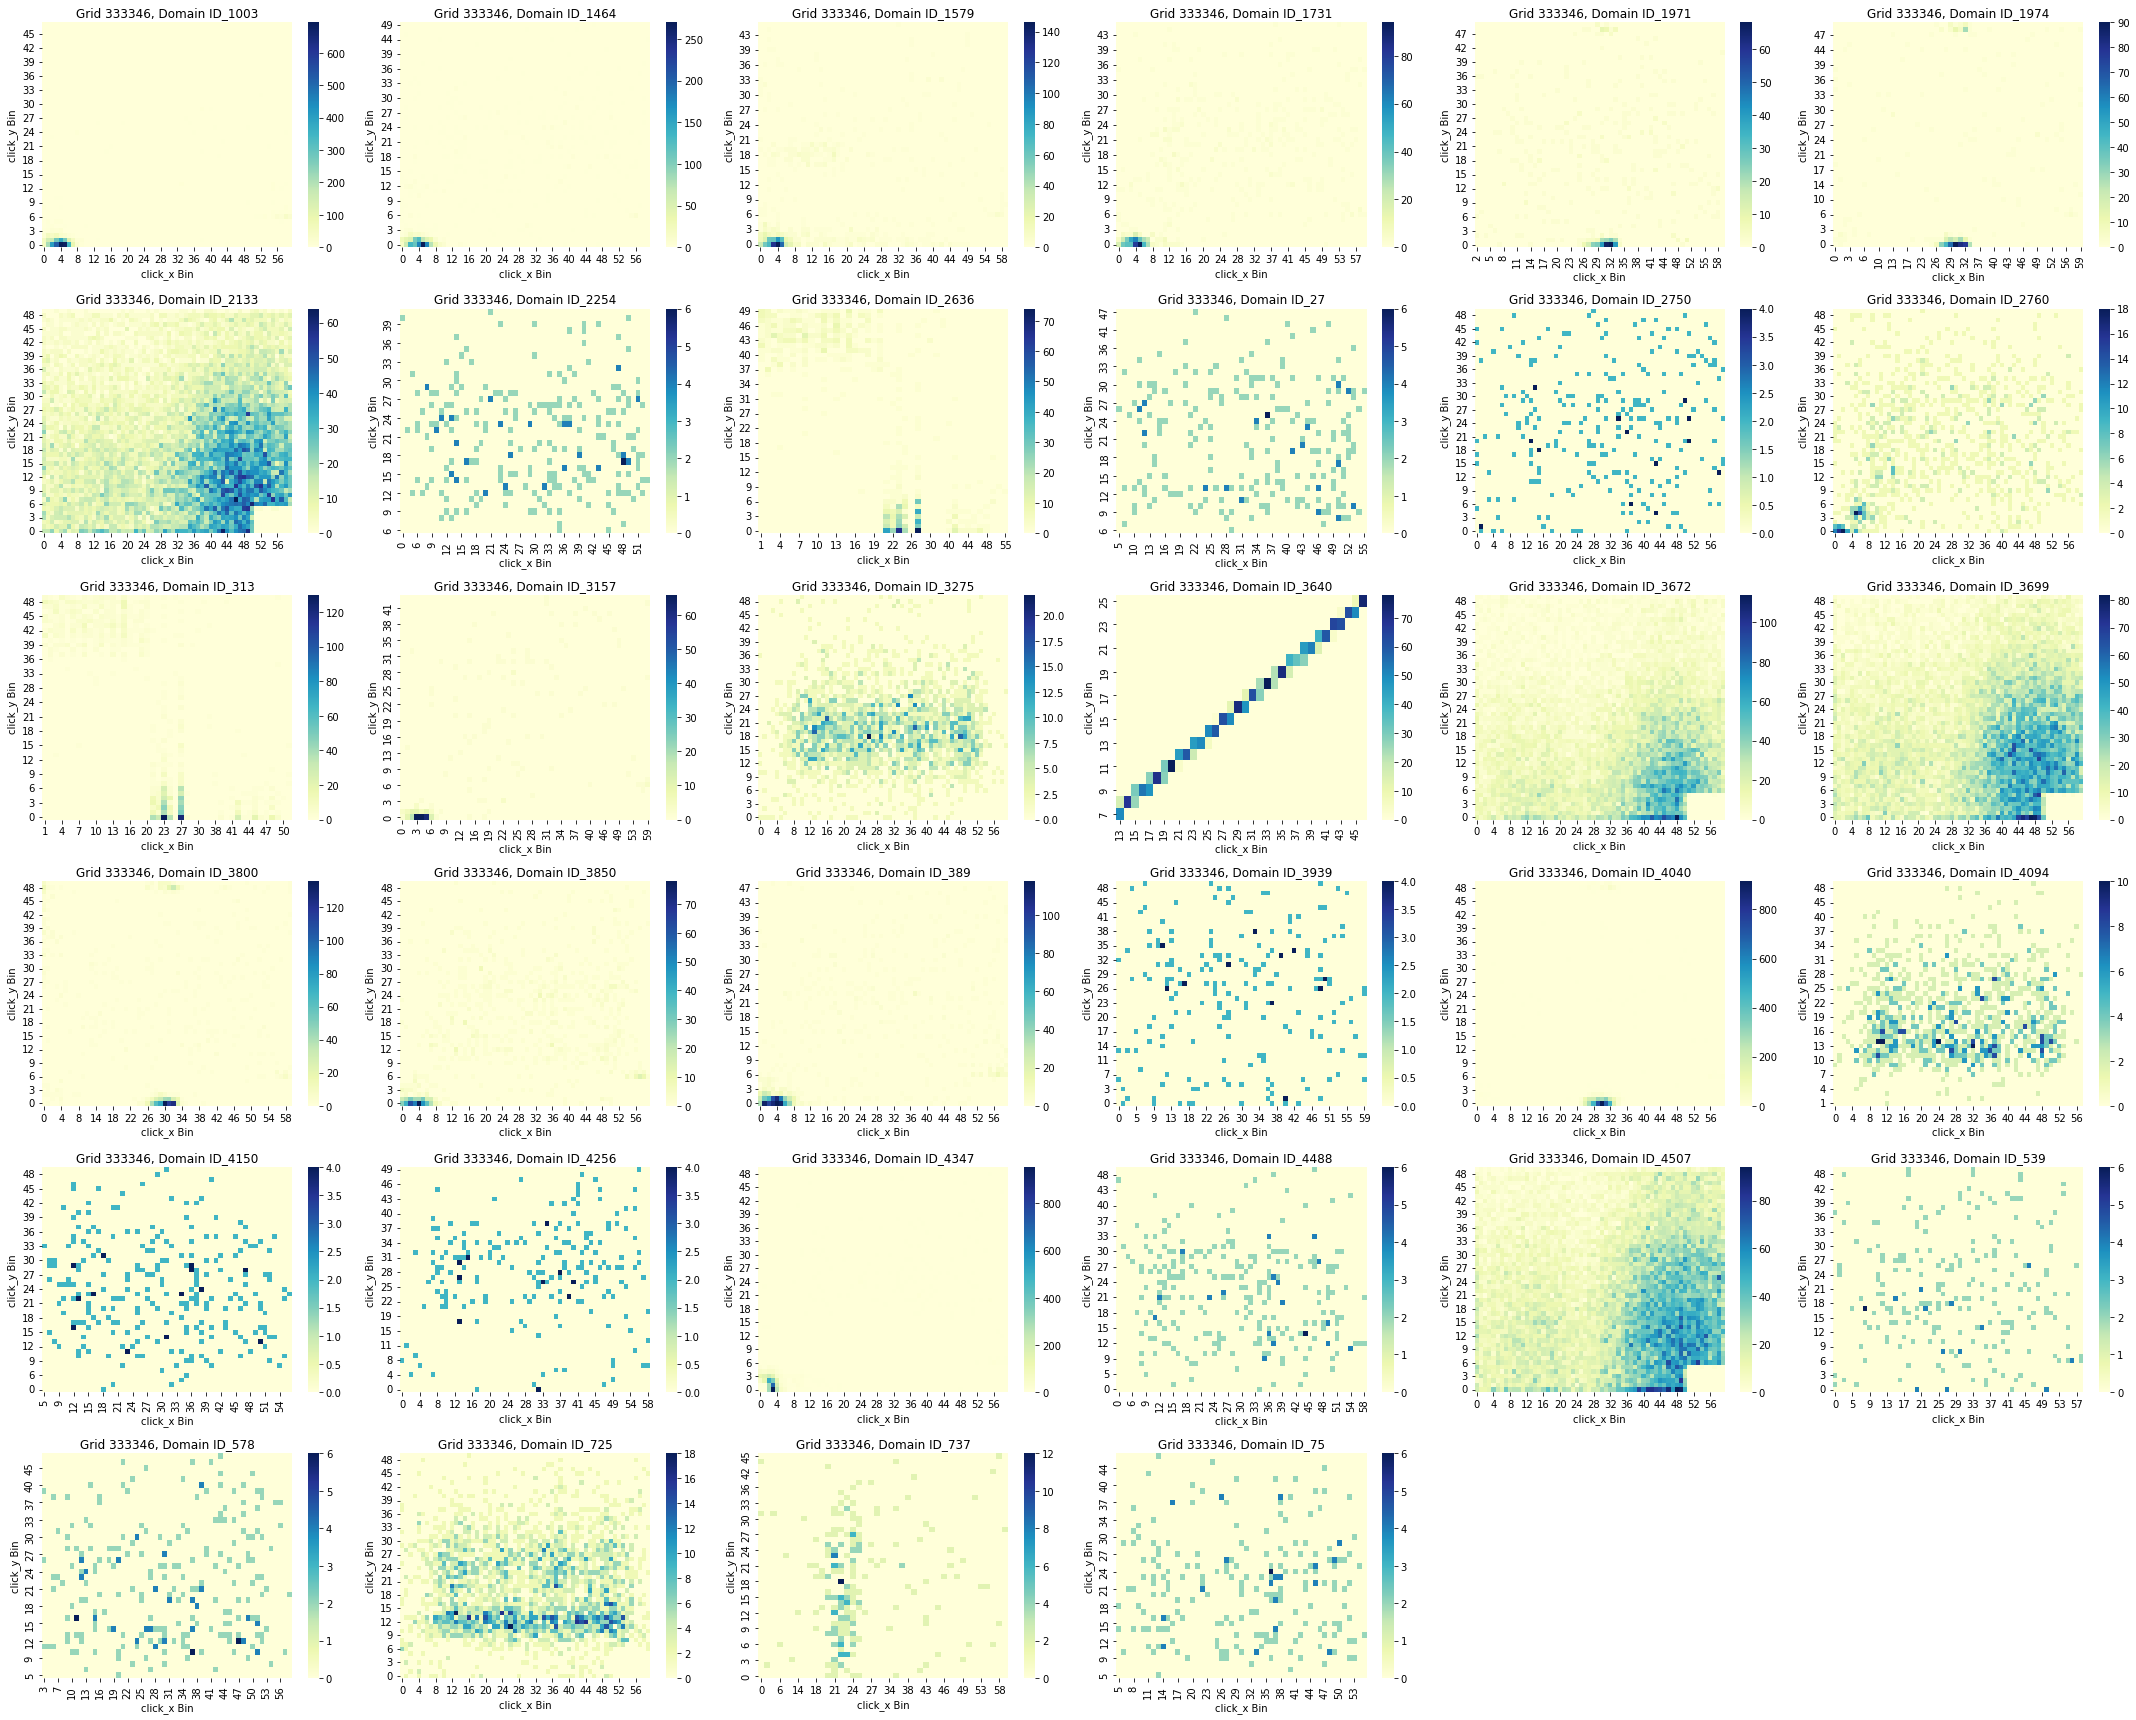

In [83]:
# Determine the number of unique pairs of (grid_id, domain)
n_unique_pairs = anomalies_clicks_346.groupby(['grid_id', 'domain']).ngroups

# Decide on the layout of the subplots (for example, a grid of 5x5 subplots if there are 25 unique pairs)
n_rows = int(np.ceil(np.sqrt(n_unique_pairs)))
n_cols = int(np.ceil(n_unique_pairs / n_rows))

# Create a large figure to accommodate all the subplots
plt.figure(figsize=(n_cols * 5, n_rows * 4))

# Iterate over each group, creating a subplot for each
for i, ((grid_id, domain), group) in enumerate(anomalies_clicks_346.groupby(['grid_id', 'domain']), start=1):
    click_matrix = group.pivot("click_y_bin", "click_x_bin", "clicks_sum").fillna(0)
    
    # Create a subplot for the current heatmap
    ax = plt.subplot(n_rows, n_cols, i)
    sns.heatmap(click_matrix, cmap="YlGnBu", annot=False, cbar=True, fmt="g", ax=ax)
    ax.set_title(f'Grid {grid_id}, Domain {domain}')
    ax.set_xlabel('click_x Bin')
    ax.set_ylabel('click_y Bin')
    ax.invert_yaxis() 

# Adjust the layout to prevent overlap
plt.tight_layout()
plt.show()


### Same Visualization

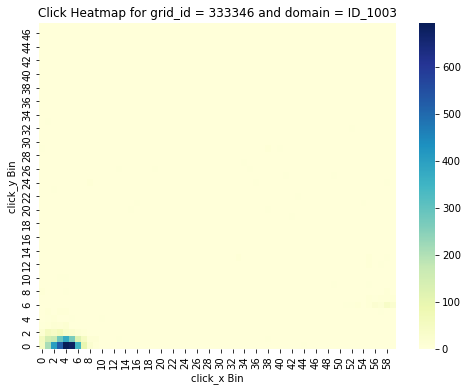

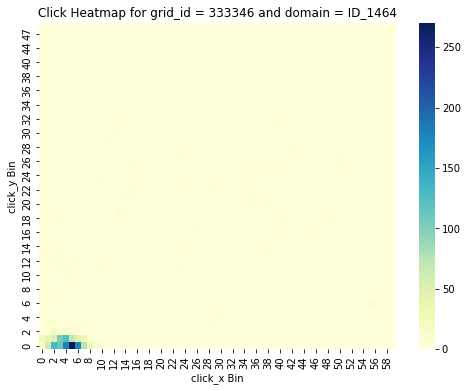

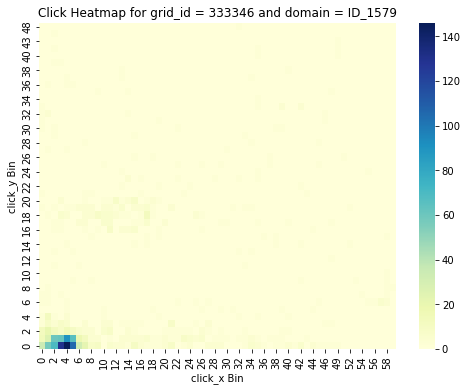

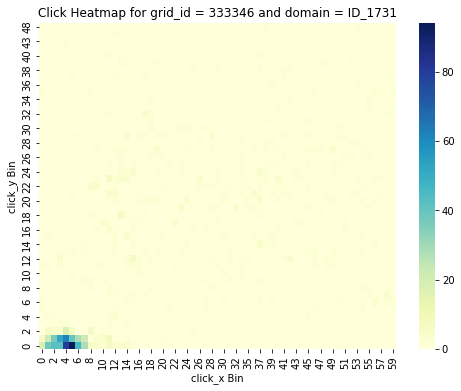

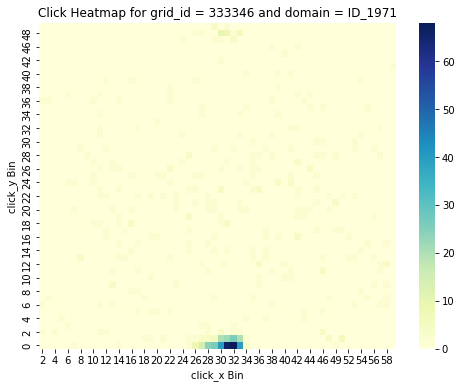

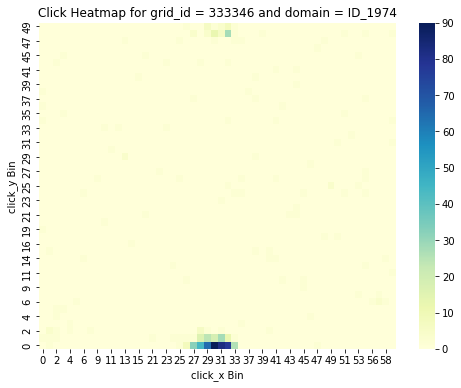

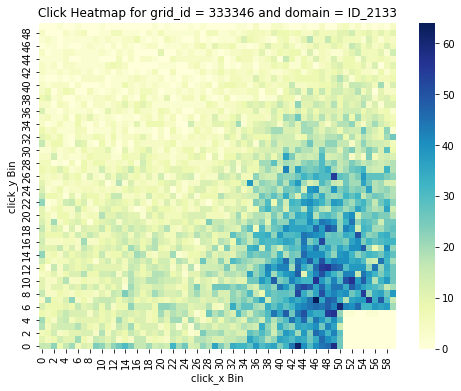

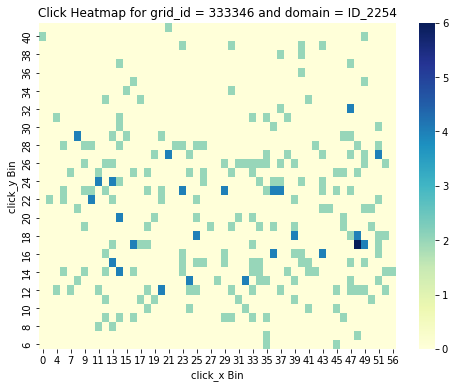

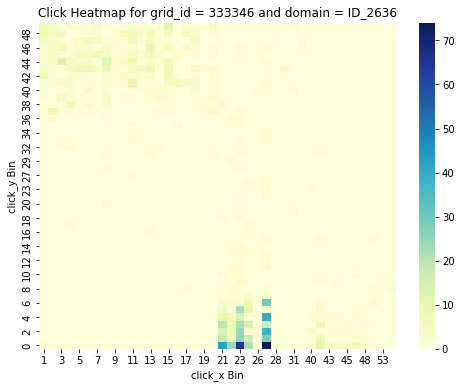

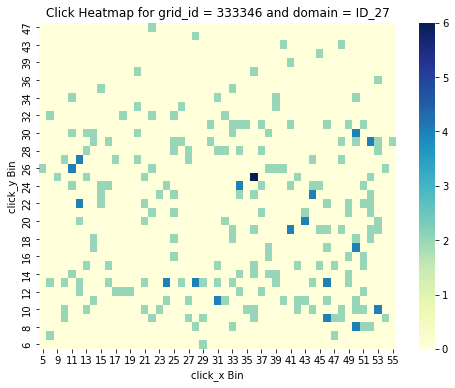

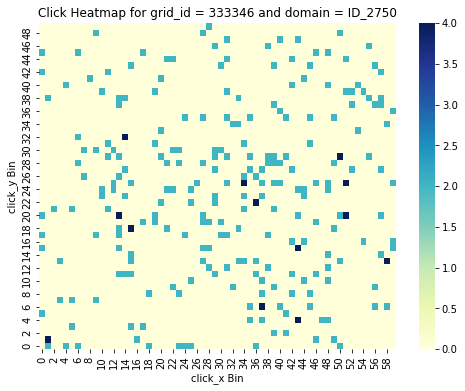

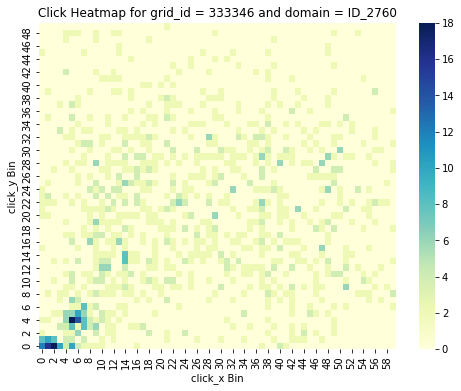

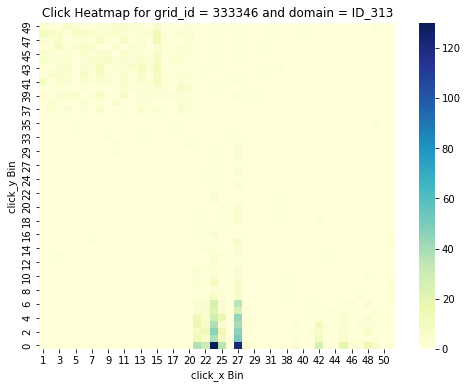

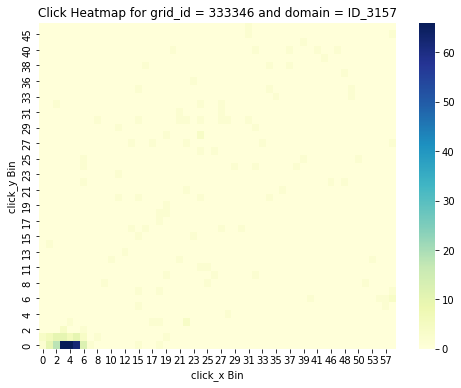

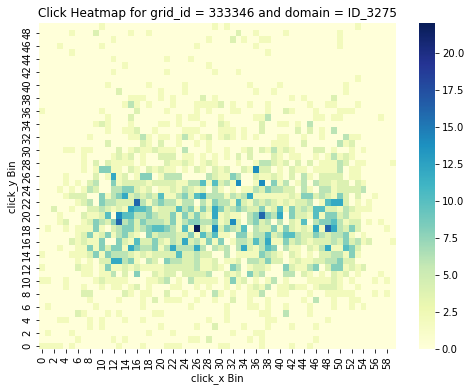

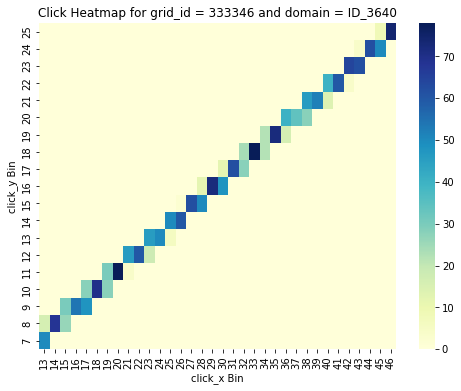

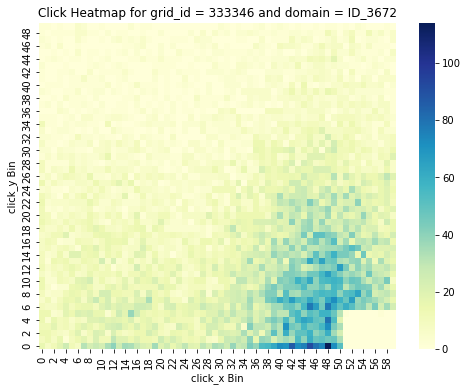

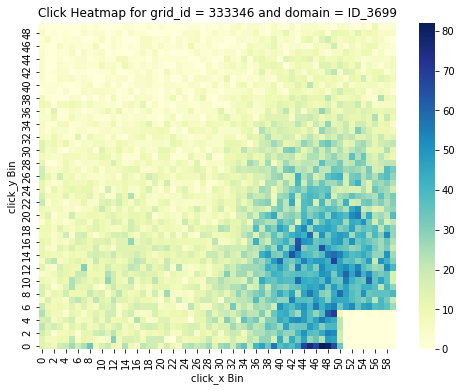

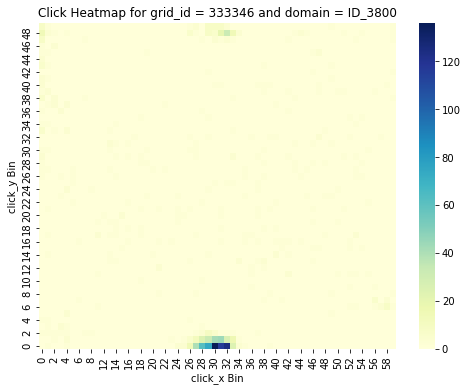

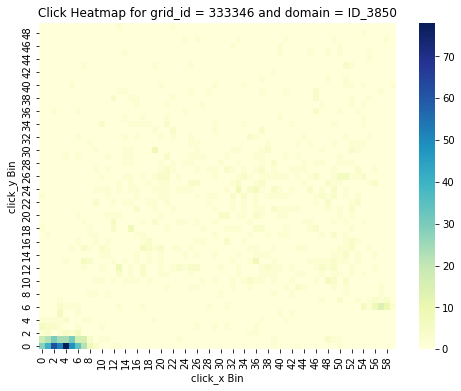

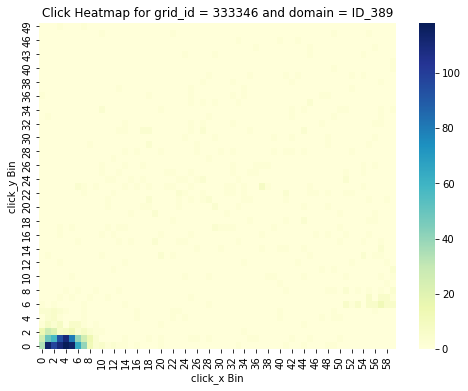

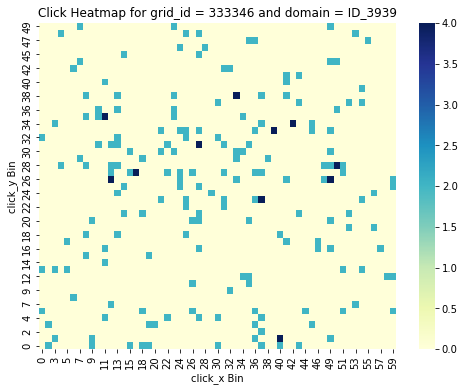

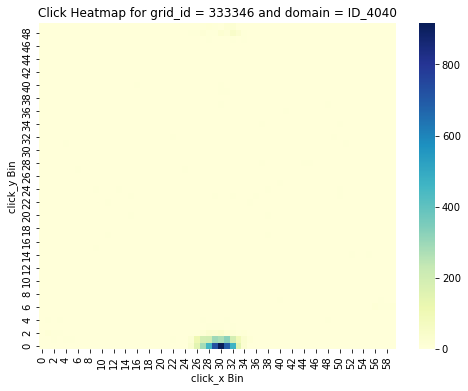

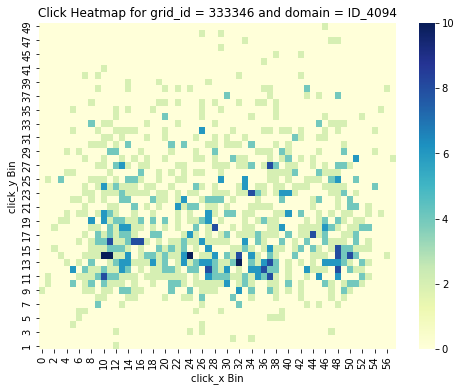

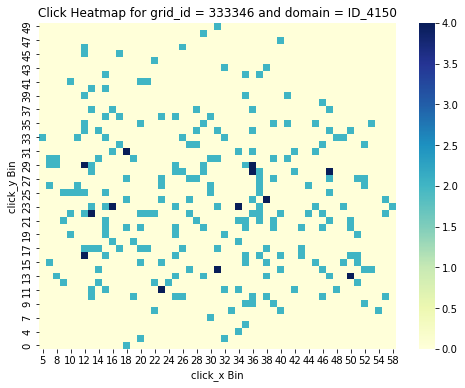

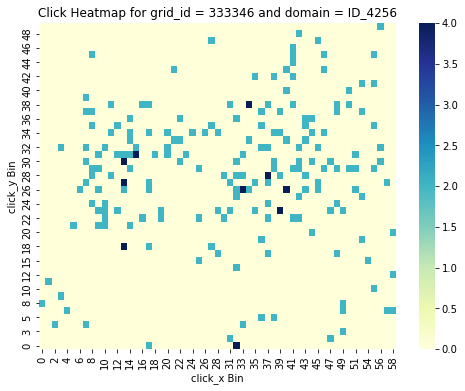

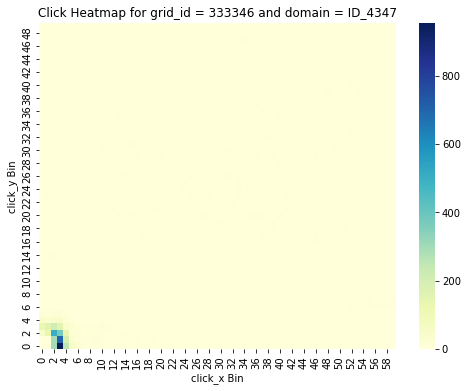

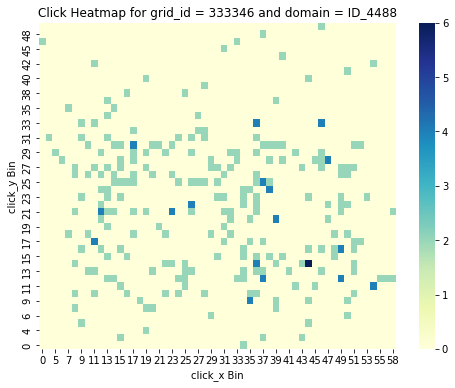

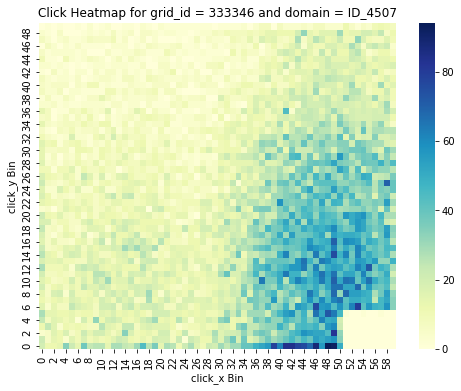

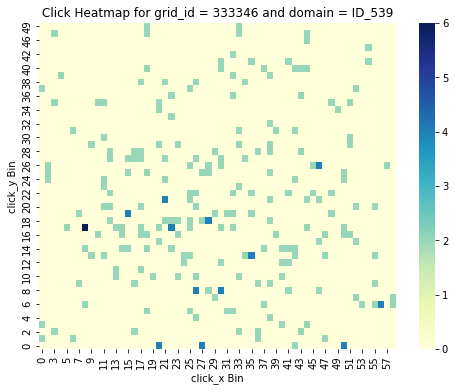

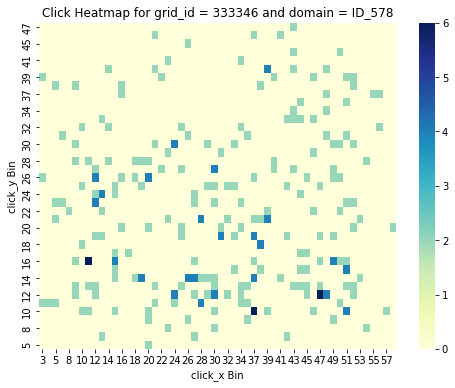

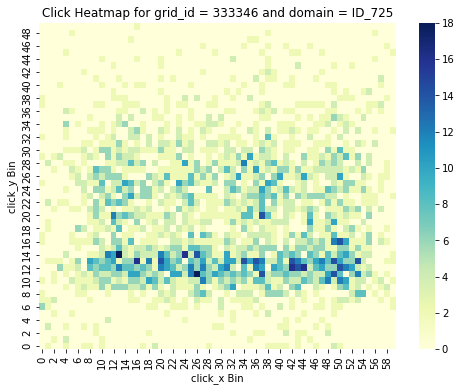

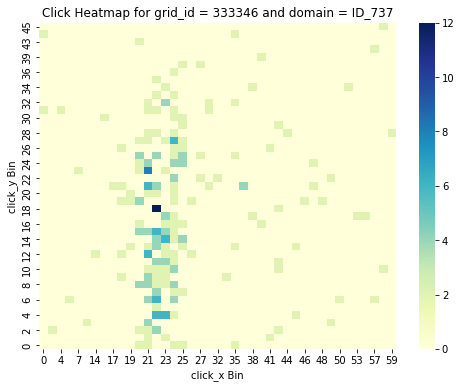

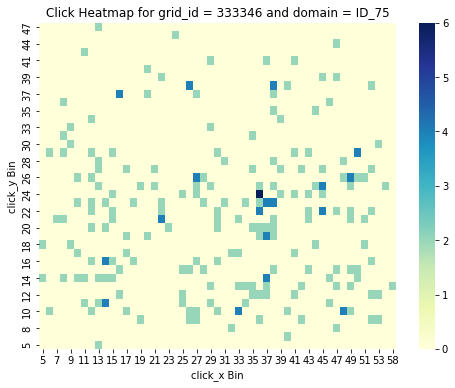

In [80]:
for (grid_id, domain), group in anomalies_clicks_346.groupby(['grid_id', 'domain']):
    click_matrix = group.pivot("click_y_bin", "click_x_bin", "clicks_sum").fillna(0)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(click_matrix, cmap="YlGnBu", annot=False, cbar=True, fmt="g")
    plt.title(f'Click Heatmap for grid_id = {grid_id} and domain = {domain}')
    plt.xlabel('click_x Bin')
    plt.ylabel('click_y Bin')
    plt.gca().invert_yaxis() 
    plt.show()

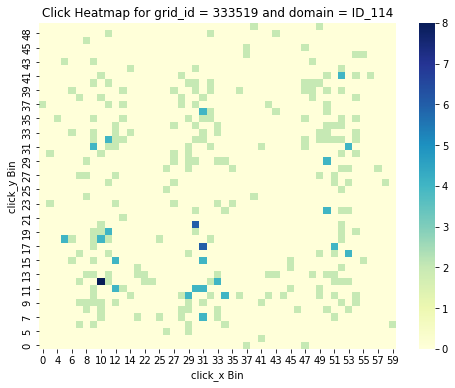

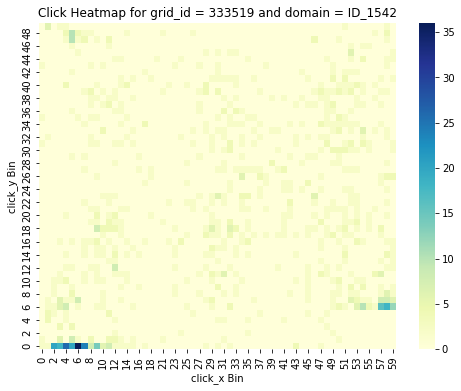

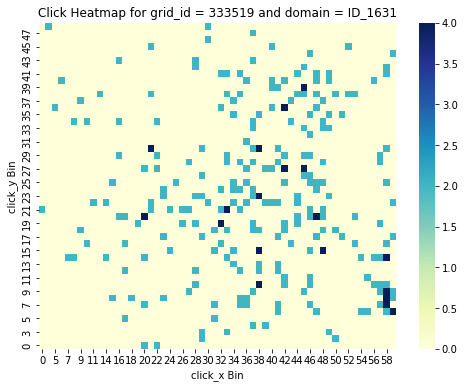

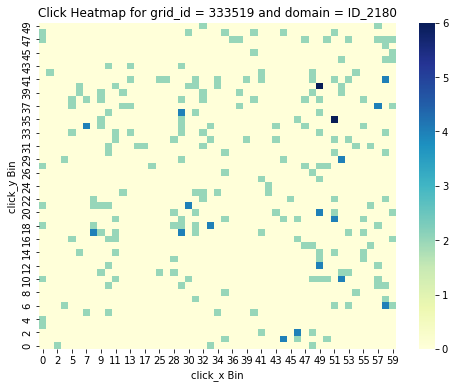

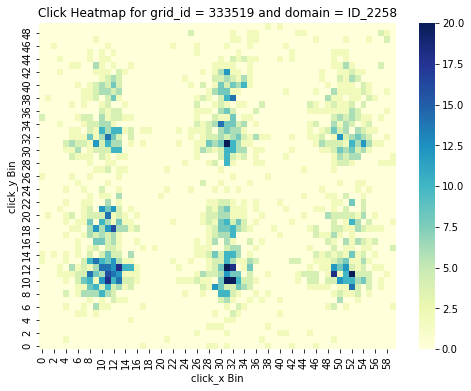

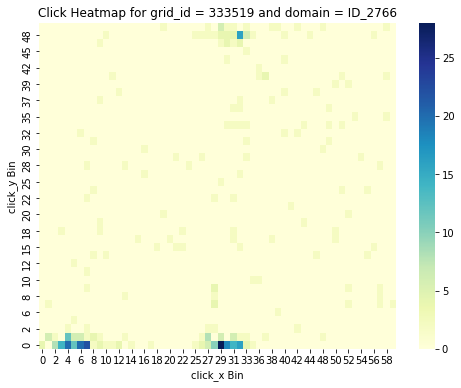

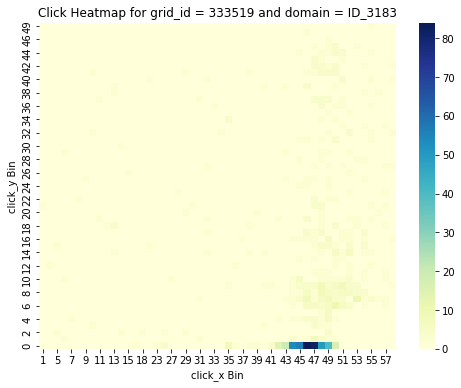

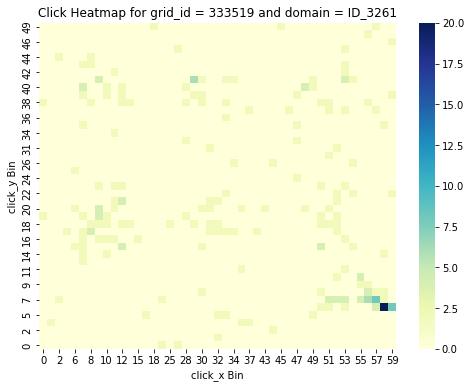

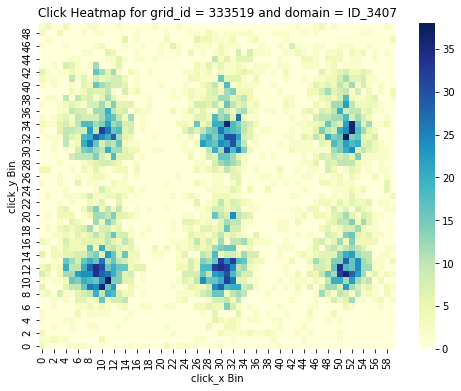

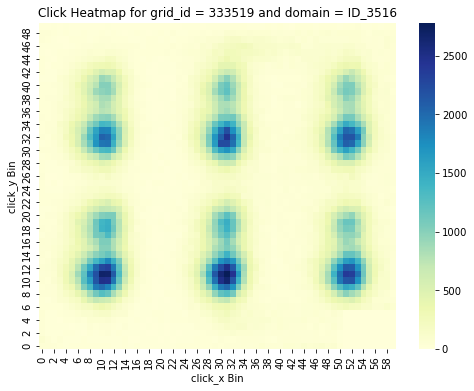

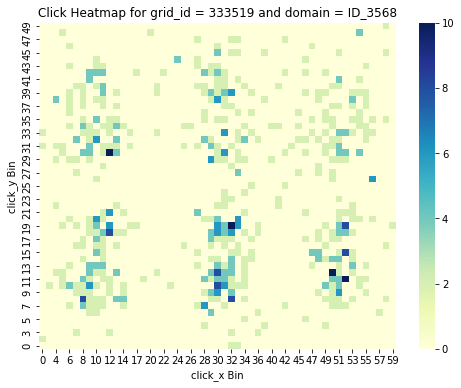

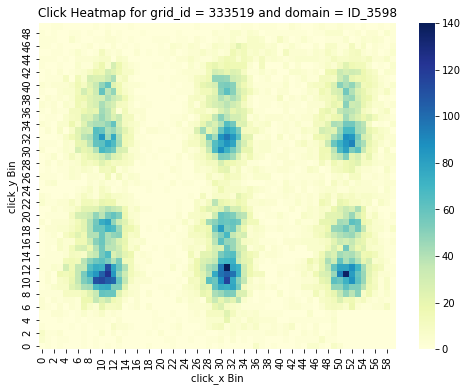

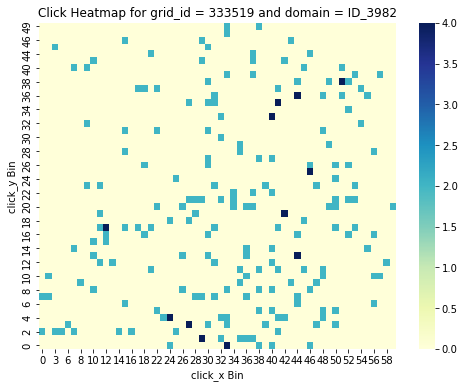

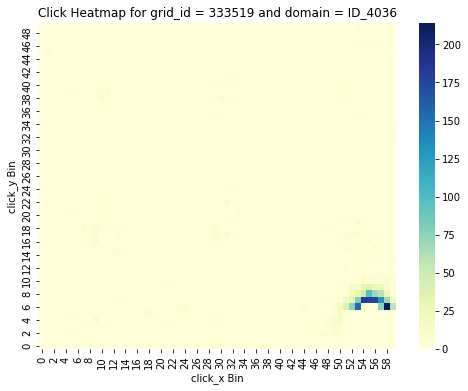

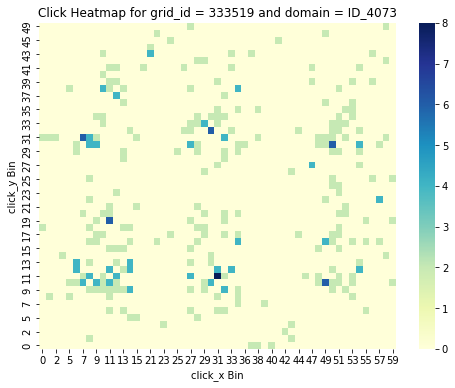

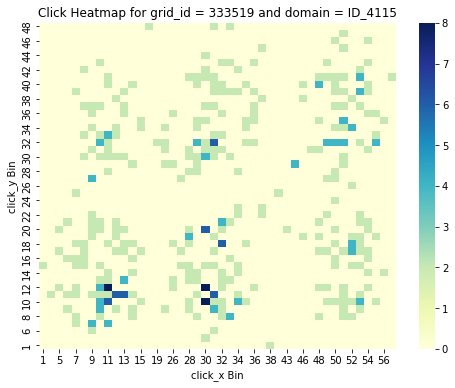

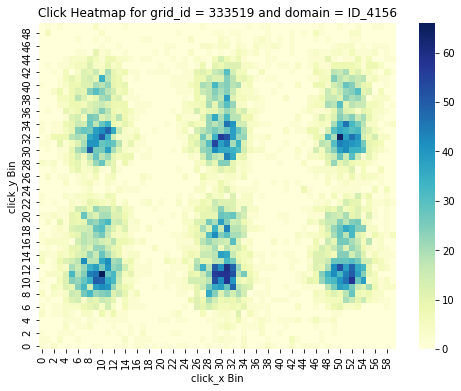

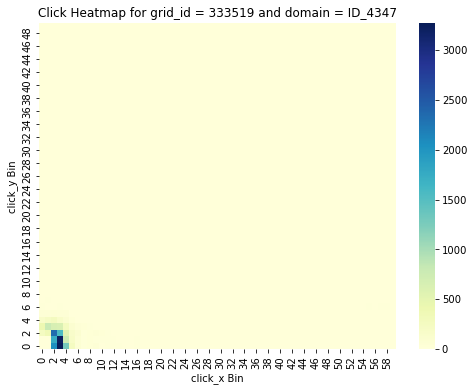

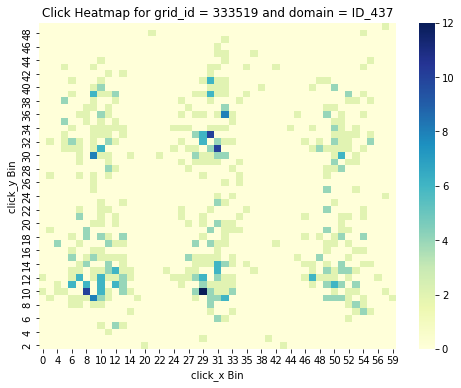

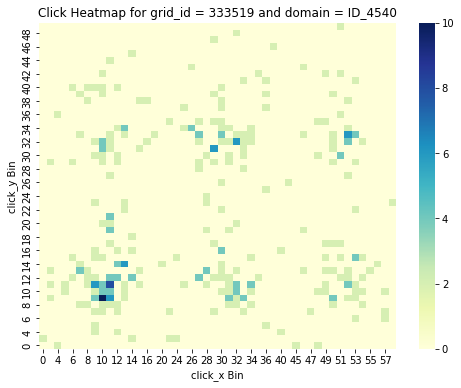

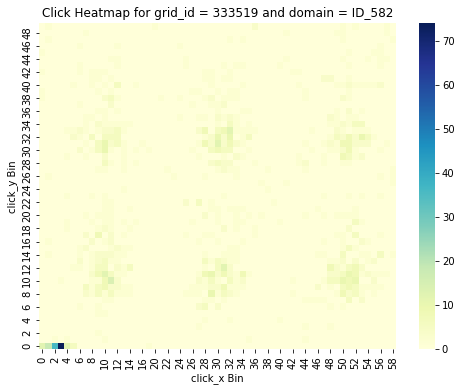

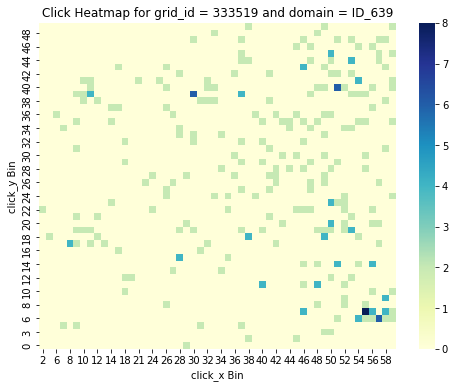

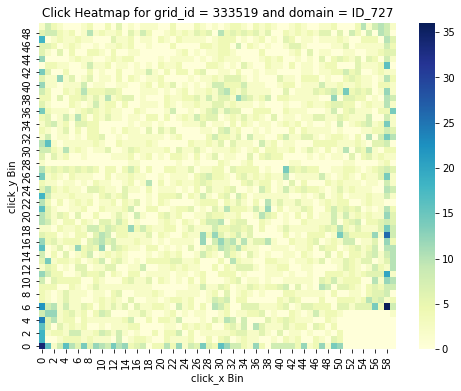

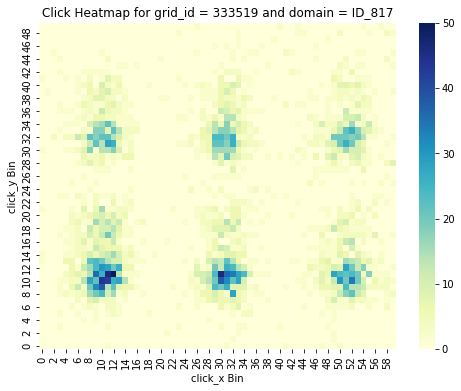

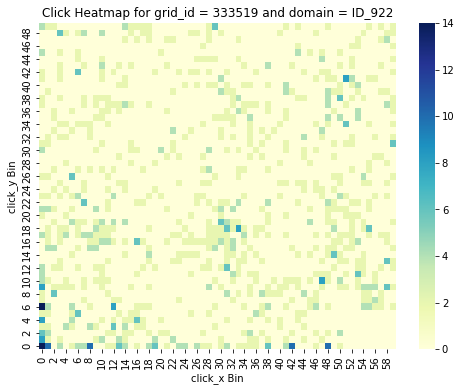

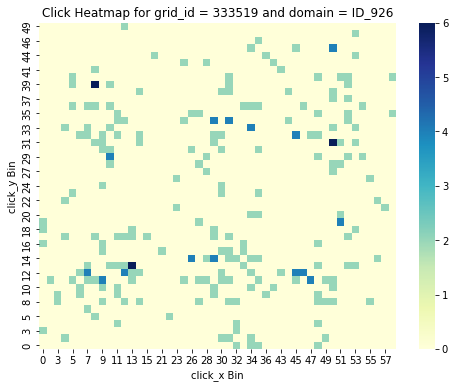

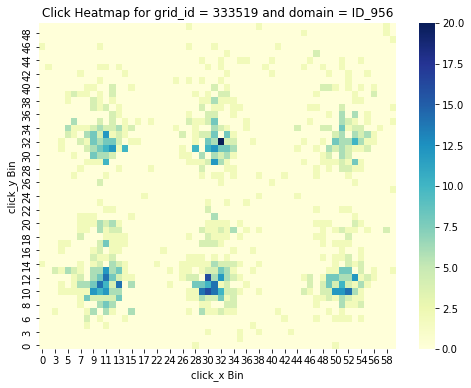

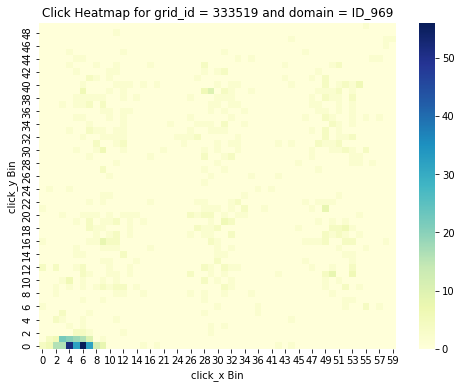

In [81]:
for (grid_id, domain), group in anomalies_clicks_519.groupby(['grid_id', 'domain']):
    click_matrix = group.pivot("click_y_bin", "click_x_bin", "clicks_sum").fillna(0)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(click_matrix, cmap="YlGnBu", annot=False, cbar=True, fmt="g")
    plt.title(f'Click Heatmap for grid_id = {grid_id} and domain = {domain}')
    plt.xlabel('click_x Bin')
    plt.ylabel('click_y Bin')
    plt.gca().invert_yaxis() 
    plt.show()